## Predicting Properties of the 1d-TFIM from Classical shadows

In this notebook we will analyse the performance of the classical shadows in predicting
properties of our quantum system. We have a few objectives: $\\$
1.) Compare the predictions of the classical shadows with exact solution at different ratios
$\frac{h}{J}$ $\\$
2.) Determine how the relative error scales with the number of measurements $\\$
3.) Compare the randomized with the derandomized measurement approach $\\$
To simplify matters we only consider the antiferromagnetic case ($J=1$) with
periodic boundary conditions. $\\$
We start by computing hundreds of measurements for different numbers of qubits and ratios
$\frac{h}{J}$ and store them in a dictionary for later use since this is the most
computationally expensive part. Moreover, we can use the same measurements to
 predict different properties. We simulate our quantum system brute force and perform
measurements on the ground state which is computationally very expensive compared to
the remaining tasks for property prediction.

In [2]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from bf_quantum_state import BFQuantumState

In [3]:
#global variables
ratios_h_j = np.array([0.01, 0.02, 0.05, 0.1,
                           0.2, 0.5, 1, 2, 5, 10, 20, 50, 100], dtype=float)
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
save_direc_measurements = Path('data/shadow_measurements/measurements_dict.npy')
save_direc_measurements_two_point_correlation_derandomized = Path('data/shadow_measurements/measurements_two_point_corr_derandomized_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()

In [13]:
qubit_num = np.array([14])
# num of measurements has to be a multiple of the batch_size, batch_size must be smaller than 500
num_of_measurements = 100000
batch_size = 100
measurement_methods = np.array(['derandomized', 'randomized'])
measurement_dict = {}
for i in range(0, np.size(qubit_num)):
    measurement_dict[str(qubit_num[i])] = {}
    for j in range(0, np.size(ratios_h_j)):
        measurement_dict[str(qubit_num[i])][str(ratios_h_j[j])] = {}
        ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]
        print('starting ratio h/J = ' + str(ratios_h_j[j]))
        for l in range(0, 2):
            observables = TfimHamiltonianOpenFermion(qubit_num[i], ratios_h_j[j], 1, 'periodic').observables_for_energy_estimation()
            # for some reason measurement_shadow cannot deal with more than 100 measurements, thus do the measurements in
            # chunks of 100
            measurement = []
            for m in range(0, int(num_of_measurements / batch_size)):
                measurement_batch = BFQuantumState(qubit_num[i],
                                   ground_state_dict[str(1)]['periodic'][str(qubit_num[i])][str(ratios_h_j[j])]).measurement_shadow(batch_size,
                                                                                                                                    measurement_methods[l], observables)
                for measurements in measurement_batch:
                    measurement.append(measurements)
            measurement_dict[str(qubit_num[i])][str(ratios_h_j[j])][measurement_methods[l]]= measurement

np.save(save_direc_measurements, measurement_dict)



starting ratio h/J = 0.01
starting ratio h/J = 0.02
starting ratio h/J = 0.05
starting ratio h/J = 0.1
starting ratio h/J = 0.2
starting ratio h/J = 0.5
starting ratio h/J = 1.0
starting ratio h/J = 2.0
starting ratio h/J = 5.0
starting ratio h/J = 10.0
starting ratio h/J = 20.0
starting ratio h/J = 50.0
starting ratio h/J = 100.0


### Comparison ground state energy: exact vs shadows
Now we compare the results achieved by our shadow method for the example of 1000
measurements with the exact solution for the ground state energy per qubit. We do this for both the
derandomized and the randomized measurement approach.

In [4]:
# load saved dictionary again
measurement_dict = np.load(save_direc_measurements, allow_pickle='TRUE')
measurement_dict = measurement_dict.item()
energy_dict = np.load(save_direc_eigs, allow_pickle='TRUE')
energy_dict = energy_dict.item()

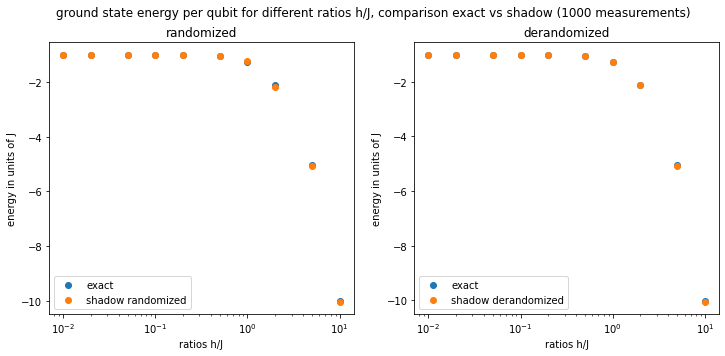

In [5]:
qubit_num = 14
num_of_measurements = 1000
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('ground state energy per qubit for different ratios h/J, comparison exact vs shadow (' + str(num_of_measurements) + ' measurements)')
measurement_methods = ['randomized', 'derandomized']
for i in range(0, 2):
    energy_shadow = np.zeros(np.size(ratios_h_j))
    energy_brute = np.zeros(np.size(ratios_h_j))
    for j in range(0, np.size(ratios_h_j)):
        measurements = measurement_dict[str(qubit_num)][str(ratios_h_j[j])][measurement_methods[i]][0:num_of_measurements]
        energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[j],
                                             1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[i], measurements)
        energy_brute[j] = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[j])][0]
    axs[i].scatter(ratios_h_j[:-3], energy_brute[:-3] / qubit_num, label = 'exact')
    axs[i].scatter(ratios_h_j[:-3], energy_shadow[:-3] / qubit_num, label = 'shadow ' + measurement_methods[i])
    axs[i].set(xscale='log', xlabel='ratios h/J',
                      ylabel='energy in units of J')
    axs[i].set_title(measurement_methods[i])
    axs[i].legend()

Now we plot the error in the ground state per qubit to see whether the shadows perform equally well for all values of
$\frac{h}{J}$. We plot both the relative and the absolute error. Since we are interested
in the mean error of 1000 measurements and not the error of this particular sample, we
split our $10^5$ measurements in 100 batches with 1000 measurements and compute the mean
error. Moreover, we compute the mean standard deviation according to the standard
formula:
\begin{equation}
\sigma^2 = \frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2
\end{equation}

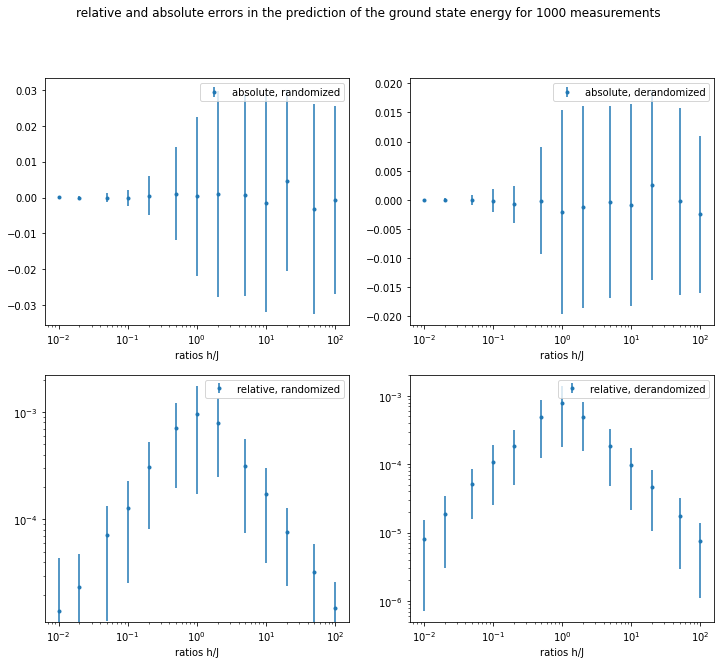

In [24]:
num_of_measurements = 1000
batches = 100
error_types = ['absolute', 'relative']
measurement_methods = ['randomized', 'derandomized']
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('relative and absolute errors in the prediction of the ground state energy for ' + str(num_of_measurements) + ' measurements')

for i in range(0,2):
    for j in range(0,2):
        error = np.zeros((batches, np.size(ratios_h_j)))
        for b in range(0, batches):
            energy_shadow = np.zeros(np.size(ratios_h_j))
            for k in range(0, np.size(ratios_h_j)):
                measurements = measurement_dict[str(qubit_num)][str(ratios_h_j[k])][measurement_methods[j]][b * num_of_measurements : (b+1) * num_of_measurements]
                energy_shadow[k] = TfimHamiltonianOpenFermion(qubit_num, ratios_h_j[k],
                                                 1, 'periodic').energy_shadow(None, num_of_measurements, measurement_methods[j], measurements)
            if error_types[i] == 'absolute':
                error[b,:] = (energy_shadow - energy_brute) / qubit_num
            if error_types[i] == 'relative':
                error[b,:] = np.abs(energy_brute - energy_shadow) / qubit_num / np.abs(energy_brute)
        error_mean = np.mean(error, axis = 0)
        error_std = np.std(error, axis = 0)
        axs[i, j].errorbar(ratios_h_j, error_mean, yerr = error_std, label = error_types[i] + ', ' + measurement_methods[j], fmt='.')
        if error_types[i] == 'absolute':
            axs[i, j].set(xscale='log', xlabel='ratios h/J')
        if error_types[i] == 'relative':
            axs[i, j].set(xscale='log', yscale = 'log', xlabel='ratios h/J')
        axs[i, j].legend()

One can see that the accuracy is lowest in the region $\frac{h}{J} = 1$.

Now we want to see how the total error scales with the number of measurements
per observable. We focus on the relative error from now on.

We plot the average relative error per qubit number for different numbers of measurements
to see how the error scales.

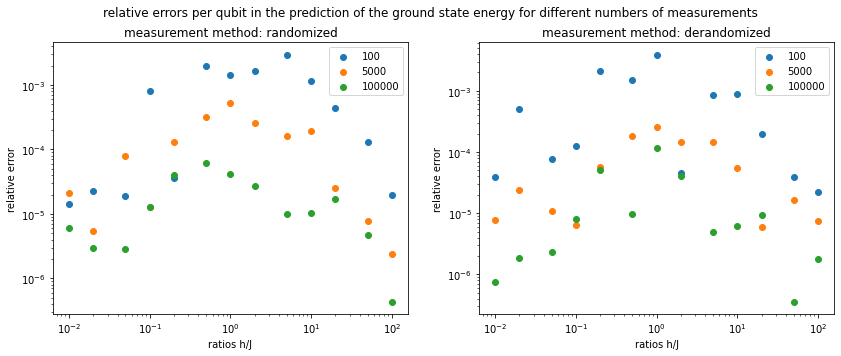

In [17]:
num_of_measurements = np.array([100, 5000, 100000])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative errors per qubit in the prediction of the ground state energy for different numbers of measurements')
for l in range(0, 2):
    for i in range(0, np.size(num_of_measurements)):
        energy_shadow = np.zeros(np.size(ratios_h_j))
        energy_brute = np.zeros(np.size(ratios_h_j))
        for j in range(0, np.size(ratios_h_j)):
            measurements = measurement_dict[str(qubit_num)][str(ratios_h_j[j])][measurement_methods[l]][0:num_of_measurements[i]]
            energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,
                                                       ratios_h_j[j], 1, 'periodic').energy_shadow(None,
                                                                                                   num_of_measurements[i],
                                                                                                   measurement_methods[l], measurements)
            energy_brute[j] = energy_dict[str(1)]['periodic'][str(qubit_num)][str(ratios_h_j[j])][0]
        errors = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute) / qubit_num
        axs[l].scatter(ratios_h_j, errors, label = num_of_measurements[i])
        axs[l].set(xscale='log', yscale='log', xlabel='ratios h/J', ylabel = 'relative error')
        axs[l].set_title('measurement method: ' + str(measurement_methods[l]))
        axs[l].legend()

The method of derandomized measurements converges faster than the randomized approach
but for big numbers of measurements (~1000) they first start performing equally well and
for $10^5$ measurements the randomized approach is equally good or maybe even better.


### Comparison Two Point Correlation: shadows vs exact
Now we compute the Two Point Correlation and compare the values computed with the shadows with
the exact values. We compute the Two Point Correlation in the Z basis. It is given by
$\langle \Psi_0 | \sigma_0^z \sigma_i^z |\Psi_0 \rangle$ . We compute the prediction for
1000 measurements and calculate again standard deviation and mean by considering
100 batches of 1000 measurements.
We will only consider the randomized case at first since for this case we can just reuse the
random measurements we already did.

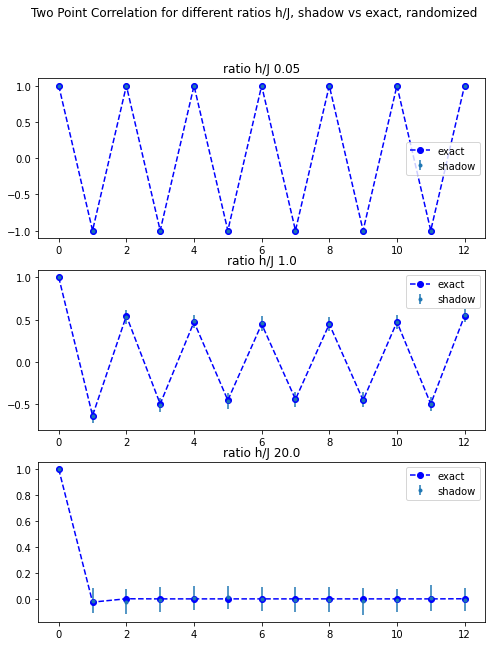

In [25]:
qubit_num = 14
num_of_measurements = 1000
batches = 100
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, shadow vs exact, randomized')
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros((batches, qubit_num - 1))
    correlation_brute = np.zeros(qubit_num - 1)
    for b in range(0, batches):
        measurement = measurement_dict[str(qubit_num)][str(some_ratios_h_j[j])]['randomized'][b * num_of_measurements:(b+1)*num_of_measurements]
        for i in range(0, qubit_num - 1):
            correlation_shadow[b,i] = BFQuantumState(qubit_num, None).two_point_correlation_shadow(num_of_measurements, measurement, 'randomized', i, 'Z')
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    corr_shadow_mean = np.mean(correlation_shadow, axis = 0)
    corr_shadow_std = np.std(correlation_shadow, axis=0)
    axs[j].errorbar(dist, corr_shadow_mean, yerr = corr_shadow_std,  label = 'shadow', fmt = '.')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))

The predictions fit the exact values very well. Now we would like to see how
the prediction accuracy improves with more measurements. We focus on the case $\frac{h}{J}=1$
and compute the absolute error.

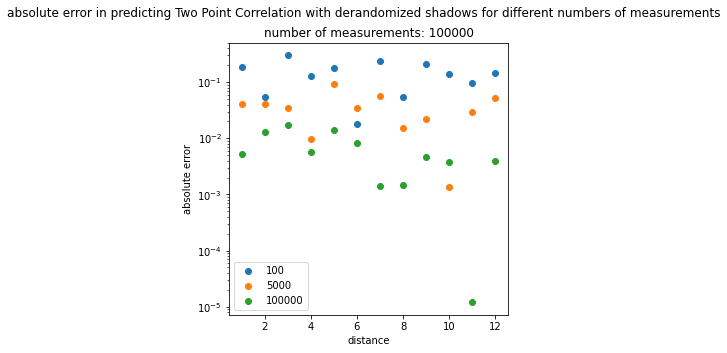

In [21]:
some_ratios_h_j = np.array([1.0])
num_of_measurements = np.array([100, 5000, 100000])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.suptitle('absolute error in predicting Two Point Correlation with derandomized shadows for different numbers of measurements')
for l in range(0, np.size(some_ratios_h_j)):
    for j in range(0, np.size(num_of_measurements)):
        correlation_brute = np.zeros(qubit_num - 1)
        correlation_shadow = np.zeros(qubit_num - 1)
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[l])]
            measurement = measurement_dict[str(qubit_num)][str(some_ratios_h_j[l])]['randomized'][0:num_of_measurements[j]]
            correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement , 'randomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
        errors = np.abs(correlation_brute - correlation_shadow)
        axs.scatter(dist[1:], errors[1:], label = num_of_measurements[j])
        axs.set_title('number of measurements: ' + str(num_of_measurements[j]))
        axs.set(xlabel='distance', ylabel = 'absolute error', yscale = 'log')
        axs.legend()


We can see that the prediction accuracy continues to improve all the way up to $10^5$
measurements.
Now we will investigate the performance of the
derandomized method for the three cases and then we will check again the convergence of
the error.



When estimating the Two Point correlations for different distances and one ratio $\frac{h}{J}$
we have to estimate the observables $\{Z_0Z_0, Z_0Z_1, \ldots ,Z_0Z_n \}$ where $n$ is the
number of qubits. Hence, the derandomization procedure simply tells us to measure the string
$Z_0 Z_1 \ldots Z_N$ over and over again. This has already been done in the energy estimation
part. Here the derandomization procedure told to measure the strings $Z_0 Z_1 \ldots Z_N$
and $X_0 X_1 \ldots X_N$ over and over again. Thus, we do not have to do the measurement twice and
can simply extract the desired measurements by using every second measurement in the
derandomized measurement file.

We determine the mean and standard deviation by splitting the 50000 measurements in
50 batches of size 1000. From the individual results we compute standard deviation
and mean.


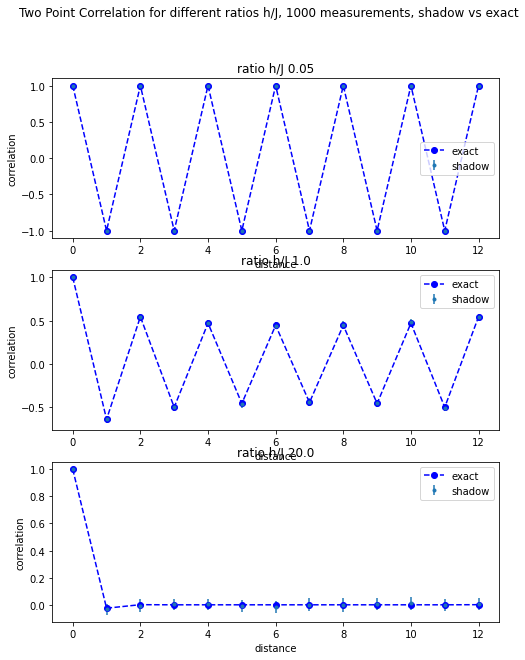

In [28]:
num_of_measurements = 1000
batches = 50
some_ratios_h_j = np.array([0.05, 1.0, 20.0])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(3,1)
fig.set_figheight(10)
fig.set_figwidth(8)
fig.suptitle('Two Point Correlation for different ratios h/J, ' + str(num_of_measurements) + ' measurements, shadow vs exact')
index_filter = np.arange(1, num_of_measurements, 2)
for j in range(0, np.size(some_ratios_h_j)):
    correlation_shadow = np.zeros((batches, qubit_num - 1))
    correlation_brute = np.zeros(qubit_num - 1)
    for b in range(0, batches):
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[j])]
            measurement = measurement_dict[str(qubit_num)][str(some_ratios_h_j[j])]['derandomized'][b*num_of_measurements:(b+1)*num_of_measurements*2]
            measurement_filtered = []
            for l in range(0, np.size(index_filter)):
                measurement_filtered.append(measurement[index_filter[l]])
            correlation_shadow[b,i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement_filtered , 'derandomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
    corr_shadow_mean = np.mean(correlation_shadow, axis=0)
    corr_shadow_std = np.std(correlation_shadow, axis=0)
    axs[j].errorbar(dist, corr_shadow_mean, yerr = corr_shadow_std, label = 'shadow', fmt='.')
    axs[j].plot(dist, correlation_brute, 'bo', linestyle = 'dashed', label = 'exact')
    axs[j].legend()
    axs[j].set_title('ratio h/J ' + str(some_ratios_h_j[j]))
    axs[j].set(xlabel = 'distance', ylabel = 'correlation')



From now on we focus on the ratio $\frac{h}{J} = 1$ where the phase transition happens
since this is the most interesting area. For this value we investigate how the prediction
accuracy of the shadows scales with the number of measurements.
We compute the absolute error at every distance. We make error plots for different
numbers of measurements and see how the prediction accuracy improves.

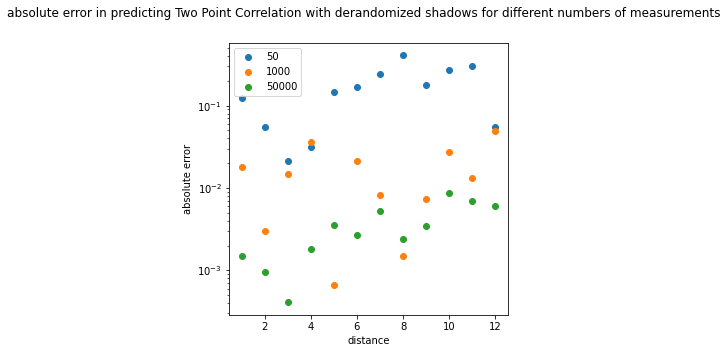

In [31]:
some_ratios_h_j = np.array([1.0])
num_of_measurements = np.array([50, 1000, 50000])
dist = np.arange(0, qubit_num - 1, 1)
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(5)
fig.suptitle('absolute error in predicting Two Point Correlation with derandomized shadows for different numbers of measurements')
for l in range(0, np.size(some_ratios_h_j)):
    for j in range(0, np.size(num_of_measurements)):
        index_filter = np.arange(1, num_of_measurements[j], 2)
        correlation_brute = np.zeros(qubit_num - 1)
        correlation_shadow = np.zeros(qubit_num - 1)
        for i in range(0, qubit_num - 1):
            ground_state = ground_state_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios_h_j[l])]
            measurement = measurement_dict[str(qubit_num)][str(some_ratios_h_j[l])]['derandomized'][0:num_of_measurements[j]*2]
            measurement_filtered = []
            for m in range(0, np.size(index_filter)):
                measurement_filtered.append(measurement[index_filter[m]])
            correlation_shadow[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation_shadow(num_of_measurements, measurement_filtered, 'derandomized', i, 'Z')
            correlation_brute[i] = BFQuantumState(qubit_num, ground_state).two_point_correlation(i, 'Z')
        errors = np.abs(correlation_brute - correlation_shadow)
        axs.scatter(dist[1:], errors[1:], label = str(num_of_measurements[j]))
    axs.legend()
    axs.set(xlabel='distance', ylabel = 'absolute error', yscale = 'log')

The error keeps converging all the way up to 50000 measurements. The accuracy obtained
is twice as good as for randomized measurements with half as many measurements. One can
see that the accuracy decreases with the distance.
